# Volume-mean temperature

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=64e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36703 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:42213 Dashboard: http://127.0.0.1:36703/status,Cluster Workers: 4 Cores: 8 Memory: 238.42 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
elif machine == 'nesh':
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'

## Read NEMO grid

In [6]:
# On sci
#ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
ds_mesh = xr.open_dataset('/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read NEMO

In [7]:
#exp_list = ['focioifs-merge14']
exp_list = ['FOCI_GJK001','foci-cpl-06']
time_list = [slice('1850-01-01','2450-01-01'), slice('1850-01-01','2450-01-01')]
#exp_list = ['FOCI_NJK007_cont3']

In [8]:
# OpenIFS surface
ds_sfc_all = []
for (time,exp) in zip(time_list,exp_list):
    if exp == 'FOCI_NJK007':
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir2,exp)
    else:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//foci-cpl-06/outdata/oifs/1y/*1y*regular_sfc.nc


In [9]:
ds_sfc

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 96, lon: 192, time: 600)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 2449-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Dimensions without coordinates: bnds
Data variables: (12/42)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    sstk               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ci                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    es                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tclw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tciw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ...                 ...
    swvl1              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl2              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl3              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl4              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    sro                (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ssro               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Mon Jan 24 08:13:52 2022: ncks -O -7 --no-alphabetize -L 1 ...
    Conventions:  CF-1.6
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2022-Jan-18 19:24:31 GMT
    uuid:         ea2bb57d-3b57-4cff-99fd-d252006ea059
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [10]:
# NEMO grid T
ds_t_all = []
for (time,exp) in zip(time_list,exp_list):
    if exp == 'FOCI_NJK007':
        t = '%s/%s/outdata/nemo/1y/*1y*grid_T.nc' % (esmdir2,exp)
    else:
        t = '%s/%s/outdata/nemo/1y/*1y*grid_T.nc' % (esmdir,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_t_all.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/1y/*1y*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//foci-cpl-06/outdata/nemo/1y/*1y*grid_T.nc


In [11]:
ds_t

<xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 46, time: 600, x: 722, y: 511)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 2449-07-01 06:00:00
    nav_lon            (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lat            (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds, x, y
Data variables: (12/18)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    deptht_bnds        (time, deptht, bnds) float32 dask.array<chunksize=(10, 46, 2), meta=np.ndarray>
    votemper           (time, deptht, y, x) float32 dask.array<chunksize=(10, 46, 511, 722), meta=np.ndarray>
    vosaline           (time, deptht, y, x) float32 dask.array<chunksize=(10, 46, 511, 722), meta=np.ndarray>
    sosstsst           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    sosaline           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    ...                 ...
    sohefldo           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    hflx_cal           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    somxl010           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    somixhgt           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    sowindsp           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
    sobowlin           (time, y, x) float32 dask.array<chunksize=(10, 511, 722), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Mon Jan 24 07:11:58 2022: ncks -O -7 --no-alphabetize -L 1 ...
    Conventions:  CF-1.6
    name:         foci-cpl-06_1m_18500101_18591231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2022-Jan-18 19:24:30 GMT
    uuid:         6188544e-6008-448f-9b80-e82ee3663250
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

## Global-mean profiles

In [12]:
toce_list = []
soce_list = []

toce_anom_list = []
soce_anom_list = []

for i in range(0,len(exp_list)):
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Globally averaged 
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) 
    toce = (ds_t['votemper'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) / tot_vol
    print(toce)
    
    # Globally averaged salinity
    soce = (ds_t['vosaline'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) / tot_vol
    print(soce)
    
    # Remove first year
    toce_anom = toce - toce[0,:]
    soce_anom = soce - soce[0,:]
    
    toce_list.append(toce.compute())
    soce_list.append(soce.compute())
    toce_anom_list.append(toce_anom.compute())
    soce_anom_list.append(soce_anom.compute())
    

<xarray.DataArray (time: 600, deptht: 46)>
dask.array<truediv, shape=(600, 46), dtype=float64, chunksize=(10, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) object 1850-07-01 06:00:00 ... 2449-07-01 06:00:00
<xarray.DataArray (time: 600, deptht: 46)>
dask.array<truediv, shape=(600, 46), dtype=float64, chunksize=(10, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) object 1850-07-01 06:00:00 ... 2449-07-01 06:00:00
<xarray.DataArray (time: 600, deptht: 46)>
dask.array<truediv, shape=(600, 46), dtype=float64, chunksize=(10, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) object 1850-07-01 06:00:00 ... 2449-07-01 06:00:00
<xarray.DataArray (time: 600, deptht: 46)>
dask.array<truediv, shape=(600, 46), dtype=float64, chunksize=(10, 46

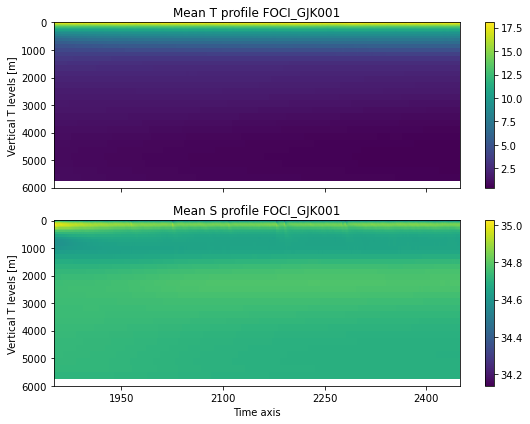

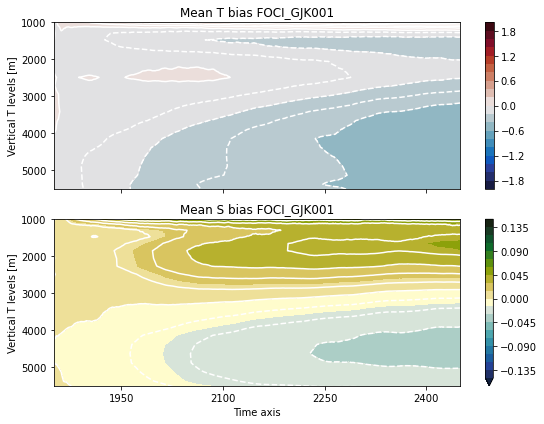

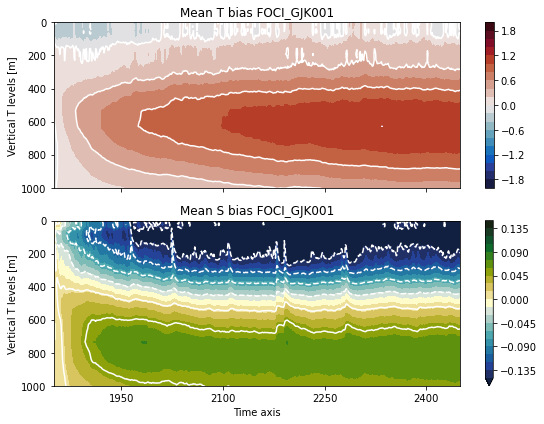

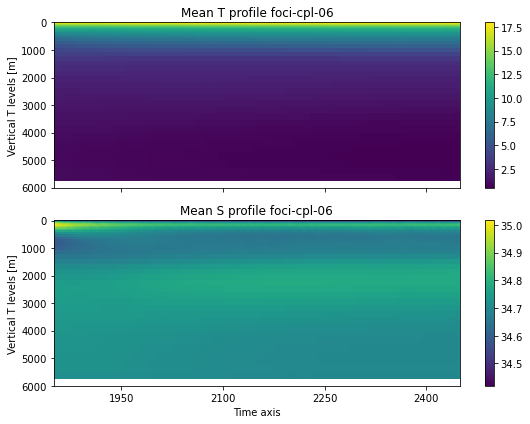

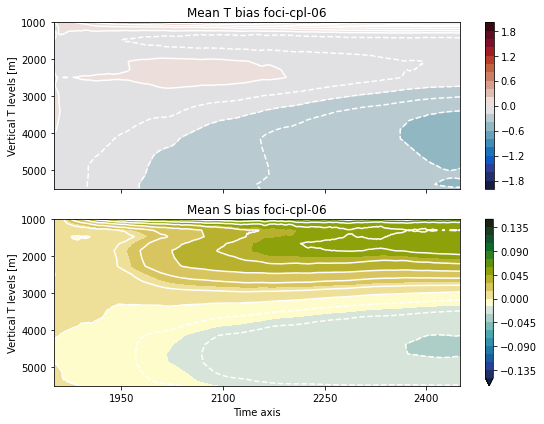

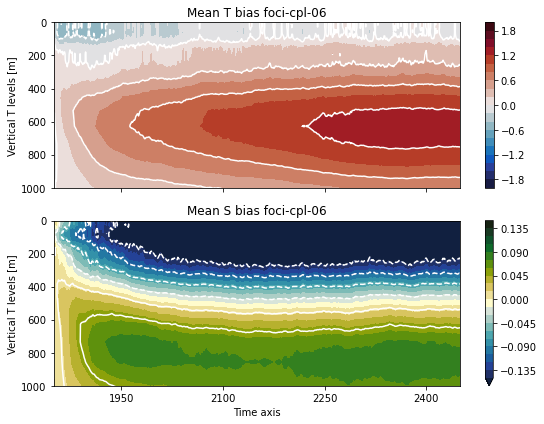

In [13]:
for i in range(0,len(exp_list)):
    
    fig1, ax1 = plt.subplots(2,1,figsize=(8,6))
    fig2, ax2 = plt.subplots(2,1,figsize=(8,6))
    fig3, ax3 = plt.subplots(2,1,figsize=(8,6))
    
    toce = toce_list[i]
    soce = soce_list[i]
    toce_anom = toce_anom_list[i]
    soce_anom = soce_anom_list[i]
    
    exp = exp_list[i]
    
    # Annual mean
    toce.plot(x='time',y='deptht',ax=ax1[0],label=exp)
    soce.plot(x='time',y='deptht',ax=ax1[1],label=exp)
    
    tlev1 = np.linspace(-2,2,21)
    tlev2 = np.arange(-2,2.1,0.4)
    tlev3 = np.arange(-2,2.1,0.1)
    slev1 = np.linspace(-0.15,0.15,21)
    slev2 = np.arange(-0.15,0.15,0.04)
    slev3 = np.arange(-0.15,0.15,0.01)
    toce_anom.plot.contourf(x='time',y='deptht',ax=ax2[0],cmap=cmocean.cm.balance,levels=tlev1)
    soce_anom.plot.contourf(x='time',y='deptht',ax=ax2[1],cmap=cmocean.cm.delta,levels=slev1)
    toce_anom.plot.contour(x='time',y='deptht',ax=ax2[0],colors='w',levels=tlev3)
    soce_anom.plot.contour(x='time',y='deptht',ax=ax2[1],colors='w',levels=slev3)
    
    toce_anom.plot.contourf(x='time',y='deptht',ax=ax3[0],cmap=cmocean.cm.balance,levels=tlev1)
    soce_anom.plot.contourf(x='time',y='deptht',ax=ax3[1],cmap=cmocean.cm.delta,levels=slev1)
    toce_anom.plot.contour(x='time',y='deptht',ax=ax3[0],colors='w',levels=tlev2)
    soce_anom.plot.contour(x='time',y='deptht',ax=ax3[1],colors='w',levels=slev2)
    
    ax1[0].set_title('Mean T profile %s' % (exp,))
    ax1[1].set_title('Mean S profile %s' % (exp,))
    
    ax2[0].set_title('Mean T bias %s' % (exp,))
    ax2[1].set_title('Mean S bias %s' % (exp,))
    
    ax3[0].set_title('Mean T bias %s' % (exp,))
    ax3[1].set_title('Mean S bias %s' % (exp,))
    
    for ax in ax2:
        ax.set_ylim([1000,5500])
    for ax in ax3:
        ax.set_ylim([0,1000])
    
    for axs in [ax1,ax2,ax3]:
        axs[0].tick_params(labelbottom=False)
        axs[0].set_xlabel('')
        for ax in axs:
            ax.invert_yaxis()

    for fig in [fig1,fig2,fig3]:
        fig.tight_layout()
        
    fig1.savefig('global_mean_ocean_profiles.png',format='png')
    fig2.savefig('global_mean_ocean_bias.png',format='png')
    fig3.savefig('global_mean_ocean_bias_upper.png',format='png')

## Volume-averaged temperature

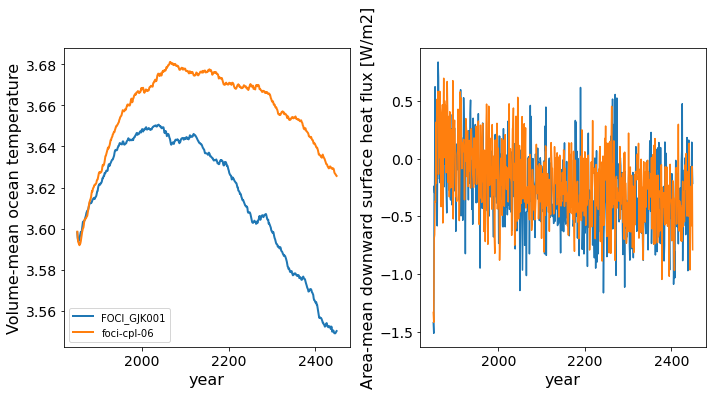

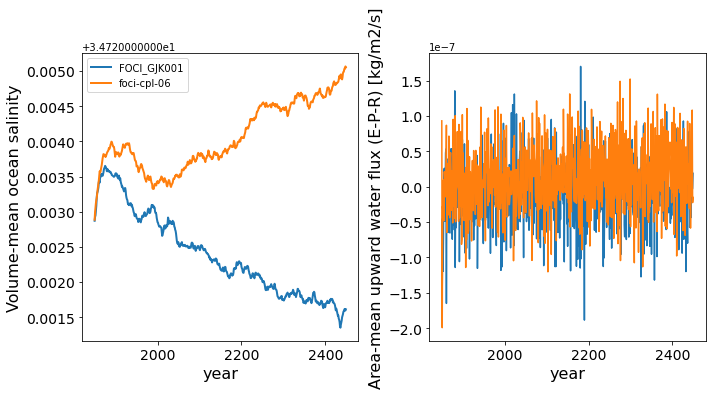

In [14]:
fig1, ax1 = plt.subplots(1,2,figsize=(10,5))

fig2, ax2 = plt.subplots(1,2,figsize=(10,5))

for i in range(0,len(exp_list)):
    toce_1d = toce_list[i]
    soce_1d = soce_list[i]
    
    exp = exp_list[i]
    ds_t = ds_t_all[i]
    
    # Ocean temperature
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) 
    toce = (toce_1d * tot_vol).sum(('deptht')) / tot_vol.sum('deptht')
    
    # Ocean salinity
    soce = (soce_1d * tot_vol).sum(('deptht')) / tot_vol.sum('deptht')
    
    # Surface heat flux
    tot_area = (da_orca05_area * da_orca05_mask).sum(('x','y')) 
    hflux = (ds_t['sohefldo'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    
    # Surface water flux
    wflux = (ds_t['sowaflup'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    
    # Annual mean
    toce_mean = toce.groupby('time.year').mean('time')
    toce_mean.plot(ax=ax1[0],alpha=1,label=exp,lw=2)
    
    soce_mean = soce.groupby('time.year').mean('time')
    soce_mean.plot(ax=ax2[0],alpha=1,label=exp,lw=2)
    
    hflux_mean = hflux.groupby('time.year').mean('time')
    hflux_mean.plot(ax=ax1[1],alpha=1,label=exp)
    
    wflux_mean = wflux.groupby('time.year').mean('time')
    wflux_mean.plot(ax=ax2[1],alpha=1,label=exp)
    
    for ax in [ax1,ax2]:
        for a in ax:
            a.tick_params(labelsize=14)
            t = a.get_xlabel()
            a.set_xlabel(t,fontsize=16)
            t = a.get_ylabel()
            a.set_ylabel(t,fontsize=16)

for ax in [ax1,ax2]:
    ax[0].legend()

ax1[0].set_ylabel('Volume-mean ocean temperature')
ax1[1].set_ylabel('Area-mean downward surface heat flux [W/m2]')
fig1.tight_layout()
fig1.savefig('volmean_ocean_temp.pdf',format='pdf')

ax2[0].set_ylabel('Volume-mean ocean salinity')
ax2[1].set_ylabel('Area-mean upward water flux (E-P-R) [kg/m2/s]')
fig2.tight_layout()
fig2.savefig('volmean_ocean_salt.pdf',format='pdf')

## Surface fluxes

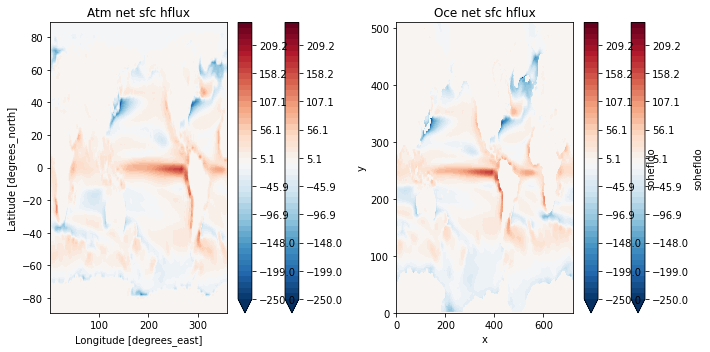

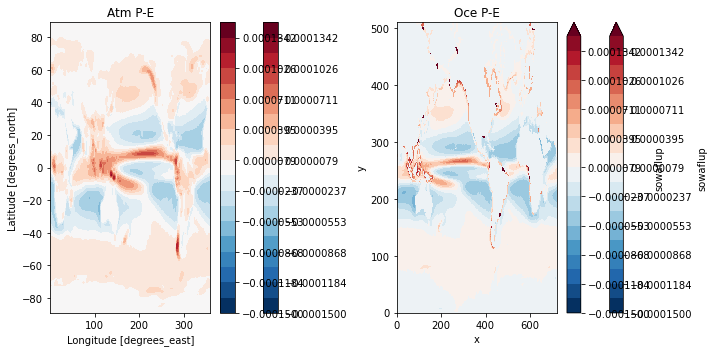

In [15]:
flux_scale = 1.0 / (6*60*60)
times = slice('1850-01-01','2150-01-01')


for i in range(0,len(exp_list)):
    exp = exp_list[i]
    ds_t = ds_t_all[i]
    ds_sfc = ds_sfc_all[i]
    
    # Ocean heat flux (solar + thermal + sensible + latent)
    oce_hflx = ds_t['sohefldo']
    
    # Atmosphere heat flux
    atm_ssr = ds_sfc['ssr'] * flux_scale
    atm_str = ds_sfc['str'] * flux_scale
    atm_shf = ds_sfc['sshf'] * flux_scale
    atm_lhf = ds_sfc['slhf'] * flux_scale
    atm_hflx = atm_ssr + atm_str + atm_shf + atm_lhf
    
    # Ocean water flux
    oce_empmr = ds_t['sowaflup']
    
    # Atm water flux
    atm_e = ds_sfc['e'] * flux_scale * 1000
    atm_p = ds_sfc['tp'] * flux_scale * 1000
    atm_emp = atm_e + atm_p
    
    # Heat fluxes
    levels = np.linspace(-250,250,50)
    atm_hflx_mean = atm_hflx.sel(time=times).mean('time')
    atm_hflx_mean.plot.contourf(ax=ax1[0],levels=levels)
    ax1[0].set_title('Atm net sfc hflux')
    
    oce_hflx_mean = oce_hflx.sel(time=times).mean('time')
    oce_hflx_mean.plot.contourf(ax=ax1[1],levels=levels)
    ax1[1].set_title('Oce net sfc hflux')
    
    # Water fluxes
    levels = np.linspace(-1.5,1.5,20) / 10000
    atm_emp_mean = atm_emp.sel(time=times).mean('time')
    atm_emp_mean.plot.contourf(ax=ax2[0],levels=levels)
    ax2[0].set_title('Atm P-E')
    
    oce_empmr_mean = oce_empmr.sel(time=times).mean('time')
    (-oce_empmr_mean).plot(ax=ax2[1],levels=levels)
    ax2[1].set_title('Oce P-E')
    
    #for ax in [ax1,ax2]:
    #    for a in ax:
    #        a.tick_params(labelsize=14)
    #        t = a.get_xlabel()
    #        a.set_xlabel(t,fontsize=16)
    #        t = a.get_ylabel()
    #        a.set_ylabel(t,fontsize=16)

fig1.tight_layout()

fig2.tight_layout()